<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2023-09-09 05:48:11.479272: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-09 05:48:11.625187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-09 05:48:11.626397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 05:48:12.388795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = "data3/train"
test_dir = "data3/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 7
FINE_TUNING_EPOCHS = 5
LR = 0.01
NUM_CLASSES = 6
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

# preprocess_fun = tf.keras.applications.densenet.preprocess_input
preprocess_fun = to_grayscale_then_rgb

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


## Data distribution (count) among differnt emotions

In [4]:
classLabelCounts = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
for classLabel, classLabelCount in zip(CLASS_LABELS, classLabelCounts):
  print(classLabel, classLabelCount)

Anger 3196
Fear 3278
Happy 5772
Neutral 3972
Sadness 3864
Surprise 2537


<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [5]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.05), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [6]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                             

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [7]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/7
  1/354 [..............................] - ETA: 1:13:29 - loss: 23.6377 - accuracy: 0.1250

2023-09-09 05:48:30.053306: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-09 05:48:30.053559: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-09 05:48:30.084154: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-09 05:48:30.084197: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.
2023-09-09 05:48:30.110722: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25214976 exceeds 10% of free system memory.


354/354 [==============================] - 248s 667ms/step - loss: 17.1860 - accuracy: 0.2652 - val_loss: 12.1723 - val_accuracy: 0.3698
Epoch 2/7
354/354 [==============================] - 252s 711ms/step - loss: 9.0513 - accuracy: 0.4101 - val_loss: 6.5661 - val_accuracy: 0.4607
Epoch 3/7
354/354 [==============================] - 225s 636ms/step - loss: 5.0535 - accuracy: 0.4873 - val_loss: 3.8606 - val_accuracy: 0.5064
Epoch 4/7
354/354 [==============================] - 227s 642ms/step - loss: 3.0749 - accuracy: 0.5356 - val_loss: 2.5855 - val_accuracy: 0.5166
Epoch 5/7
354/354 [==============================] - 232s 656ms/step - loss: 2.0879 - accuracy: 0.5625 - val_loss: 1.9401 - val_accuracy: 0.5110
Epoch 6/7
354/354 [==============================] - 225s 634ms/step - loss: 1.5824 - accuracy: 0.5844 - val_loss: 1.5070 - val_accuracy: 0.5610
Epoch 7/7
354/354 [==============================] - 223s 631ms/step - loss: 1.3203 - accuracy: 0.6076 - val_loss: 1.3083 - val_accuracy: 

## Fine Tuning

In [8]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)

Epoch 1/5
354/354 [==============================] - 238s 637ms/step - loss: 1.1692 - accuracy: 0.6380 - val_loss: 1.1950 - val_accuracy: 0.6233
Epoch 2/5
354/354 [==============================] - 226s 637ms/step - loss: 1.1439 - accuracy: 0.6477 - val_loss: 1.1812 - val_accuracy: 0.6284
Epoch 3/5
354/354 [==============================] - 227s 641ms/step - loss: 1.1343 - accuracy: 0.6504 - val_loss: 1.1733 - val_accuracy: 0.6330
Epoch 4/5
354/354 [==============================] - 222s 626ms/step - loss: 1.1276 - accuracy: 0.6517 - val_loss: 1.1660 - val_accuracy: 0.6349
Epoch 5/5
354/354 [==============================] - 223s 630ms/step - loss: 1.1121 - accuracy: 0.6553 - val_loss: 1.1592 - val_accuracy: 0.6342


In [17]:
history = history._append(pd.DataFrame(history_.history) , ignore_index=True)

## Model Evaluation

In [18]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

111/111 [==============================] - 19s 172ms/step


## Confusion Matrix

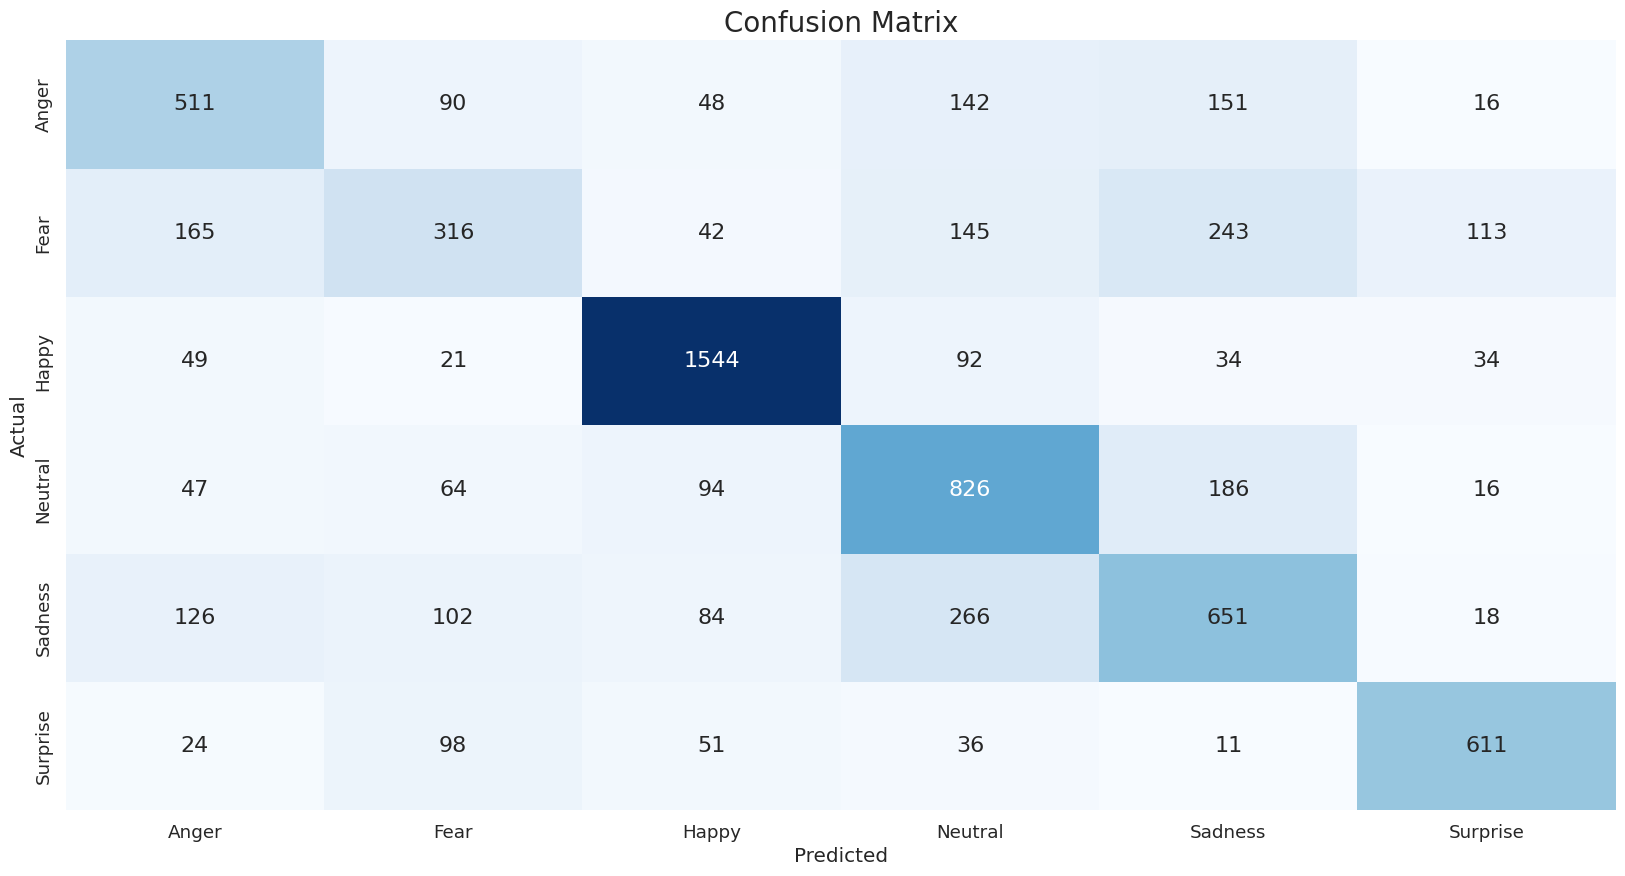

In [19]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [12]:
model.save('../cfg/model.h5')

In [23]:
from sklearn. metrics import f1_score
f1_score(y_preds, y_test, average="weighted")

0.6377740024451758

In [13]:
# ! pip install -q kaggle
# from google.colab import files
#
# files.upload()
# ! mkdir ~/.kaggle
#
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [14]:
# ! kaggle datasets download -d ananthu017/emotion-detection-fer

In [15]:
# import zipfile
# import os
#
# data_r = zipfile.ZipFile('/content/emotion-detection-fer.zip', 'r')
# data_r.extractall()

In [16]:
# import shutil, sys
# shutil.rmtree('/content/test/disgusted')